<a href="https://colab.research.google.com/github/vvvipindsm/Interview/blob/master/working_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install fiftyone
!pip install pandas 
!pip install pmdarima
!pip install seaborn 
!pip install statsmodels 
!pip install yfinance
import statsmodels.api as sm
import yfinance
import pandas as pd
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf

In [11]:

nifty_raw_data = yfinance.download (tickers = "^NSEI ^GSPC", start = "2008-01-08", 
                              end = "2022-07-06", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)
stocks_raw_data = yfinance.download (tickers = "FEDERALBNK.NS", start = "2008-01-08", 
                              end = "2022-07-06", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

stocks_raw_data.head()

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2008-01-08,28.112010,28.112010,26.653751,27.038568,5343770
2008-01-09,26.977806,27.949979,26.329691,27.366674,5576690
2008-01-10,27.544911,28.598098,27.544911,27.873018,10035660
2008-01-11,27.787950,28.148464,27.228952,27.828457,4510450
2008-01-14,28.026945,28.274039,27.605669,27.751495,4738180


In [12]:
df_comp = nifty_raw_data.copy()
df_stock = stocks_raw_data.copy()
df_comp['nifty'] = df_comp['^NSEI'].Close[:]
df_comp['kpi'] = df_stock.Close[:]


df_comp['Qkpi'] = df_stock.Volume[:]
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp = df_comp.iloc[1:]
del df_comp['^GSPC']
del df_comp['^NSEI']

df_stock=df_stock.asfreq('b')
df_stock=df_stock.fillna(method='ffill')

df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')
df_comp = df_comp[-len(df_stock):]

In [13]:
#spa
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100


df_comp['ret_nifty'] = df_comp.nifty.pct_change(1).mul(100)
df_comp['norm_ret_nifty'] = df_comp.ret_nifty.div(df_comp.ret_nifty[1])*100

# # kpi
df_comp['ret_kpi'] = df_comp.kpi.pct_change(1).mul(100)
df_comp['norm_ret_kpi'] = df_comp.ret_kpi.div(df_comp.ret_kpi[1])*100

# # kpi volumn
df_comp['ret_Qkpi'] = df_comp.Qkpi.pct_change(1).mul(100)
df_comp['norm_ret_Qkpi'] = pd.DataFrame(df_comp.ret_Qkpi.div(df_comp.ret_Qkpi[1])*100)


In [72]:

#divide into train and validation set

size = int(len(df_comp)*0.8)
train, valid = df_comp.iloc[:size], df_comp.iloc[size:]

train.tail()

,nifty,kpi,Qkpi,spx,ret_spx,norm_ret_spx,ret_nifty,norm_ret_nifty,ret_kpi,norm_ret_kpi,ret_Qkpi,norm_ret_Qkpi
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2019-08-05,10862.599609,86.697594,14302691.0,2844.739990,-2.977782,-218.567514,-1.225295,486.083612,0.114549,9.439739,5.472475,125.552334
2019-08-06,10948.250000,87.441566,9389820.0,2881.770020,1.301702,95.544169,0.788489,-312.799329,0.858124,70.716315,-34.349277,-788.058723
2019-08-07,10855.500000,86.102417,9260483.0,2883.979980,0.076688,5.628828,-0.847167,336.077509,-1.531479,-126.206216,-1.377417,-31.601412
2019-08-08,11032.450195,86.598396,12729824.0,2938.090088,1.876230,137.714245,1.630051,-646.653231,0.576034,47.469847,37.463931,859.516713
2019-08-09,11109.650391,87.193573,11961334.0,2918.649902,-0.661661,-48.565516,0.699756,-277.598210,0.687284,56.637710,-6.036926,-138.502240


In [15]:
from pmdarima.arima import auto_arima

In [73]:
para_index =1
model = auto_arima(train.ret_kpi[para_index:],exogenous = train[['ret_nifty','Qkpi']][para_index:],start_q=1,max_p=6,max_q=6,m=12,seasonal=True,max_P=2, max_D=2,max_Q=2,
                            max_d=2,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True,information_criterion="aic",alpha=0.05,scoring='mse')
best_params = model.get_params()
order = best_params['order']
seasonal_order = best_params['seasonal_order']
trend = best_params['trend']

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=12852.695, Time=4.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14512.127, Time=1.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=13704.720, Time=2.90 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12893.808, Time=2.47 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=35706.450, Time=0.78 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=12850.698, Time=3.07 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=12851.490, Time=1.60 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=12852.666, Time=8.15 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=12851.055, Time=3.51 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=12854.748, Time=9.45 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=12849.580, Time=3.09 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=12850.381, Time=1.36 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=12851.576, Time=3.13 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=12851.547, Time=6.43 sec
 ARIM

/Users/vipinv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/vipinv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=15136.345, Time=2.10 sec
 ARIMA(0,1,4)(0,0,0)[12] intercept   : AIC=12557.815, Time=1.94 sec
 ARIMA(0,1,4)(1,0,0)[12] intercept   : AIC=12558.960, Time=7.25 sec
 ARIMA(0,1,4)(0,0,1)[12] intercept   : AIC=12557.736, Time=4.14 sec
 ARIMA(0,1,4)(1,0,1)[12] intercept   : AIC=12560.512, Time=4.49 sec
 ARIMA(0,1,4)(0,0,2)[12] intercept   : AIC=12559.751, Time=10.70 sec
 ARIMA(0,1,4)(1,0,2)[12] intercept   : AIC=12562.679, Time=10.88 sec
 ARIMA(1,1,4)(0,0,1)[12] intercept   : AIC=12586.479, Time=11.27 sec


/Users/vipinv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,5)(0,0,1)[12] intercept   : AIC=15207.276, Time=5.05 sec


/Users/vipinv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/vipinv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,1)[12] intercept   : AIC=15129.037, Time=4.03 sec
 ARIMA(1,1,5)(0,0,1)[12] intercept   : AIC=12532.796, Time=5.88 sec
 ARIMA(1,1,5)(0,0,0)[12] intercept   : AIC=12532.958, Time=2.46 sec
 ARIMA(1,1,5)(1,0,1)[12] intercept   : AIC=12535.099, Time=6.11 sec
 ARIMA(1,1,5)(0,0,2)[12] intercept   : AIC=12534.834, Time=12.02 sec
 ARIMA(1,1,5)(1,0,0)[12] intercept   : AIC=12533.714, Time=4.07 sec
 ARIMA(1,1,5)(1,0,2)[12] intercept   : AIC=12537.229, Time=13.16 sec
 ARIMA(2,1,5)(0,0,1)[12] intercept   : AIC=12555.785, Time=6.48 sec
 ARIMA(1,1,6)(0,0,1)[12] intercept   : AIC=12547.922, Time=5.97 sec
 ARIMA(0,1,6)(0,0,1)[12] intercept   : AIC=12528.018, Time=5.84 sec
 ARIMA(0,1,6)(0,0,0)[12] intercept   : AIC=12528.283, Time=2.47 sec
 ARIMA(0,1,6)(1,0,1)[12] intercept   : AIC=12530.266, Time=5.99 sec
 ARIMA(0,1,6)(0,0,2)[12] intercept   : AIC=12530.050, Time=12.01 sec
 ARIMA(0,1,6)(1,0,0)[12] intercept   : AIC=12528.847, Time=4.74 sec
 ARIMA(0,1,6)(1,0,2)[12] intercept   : AIC=12

/Users/vipinv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,5)(0,0,1)[12]             : AIC=15205.275, Time=4.63 sec
 ARIMA(1,1,6)(0,0,1)[12]             : AIC=12545.798, Time=5.41 sec
 ARIMA(1,1,5)(0,0,1)[12]             : AIC=12529.045, Time=5.64 sec

Best model:  ARIMA(0,1,6)(0,0,1)[12]          
Total fit time: 318.331 seconds


In [74]:
model

ARIMA(order=(0, 1, 6), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [75]:
df_auto_pred = pd.DataFrame(model.predict(n_periods = len(valid),
                            exogenous = valid[['ret_nifty','Qkpi']]),
                            index = valid.index)

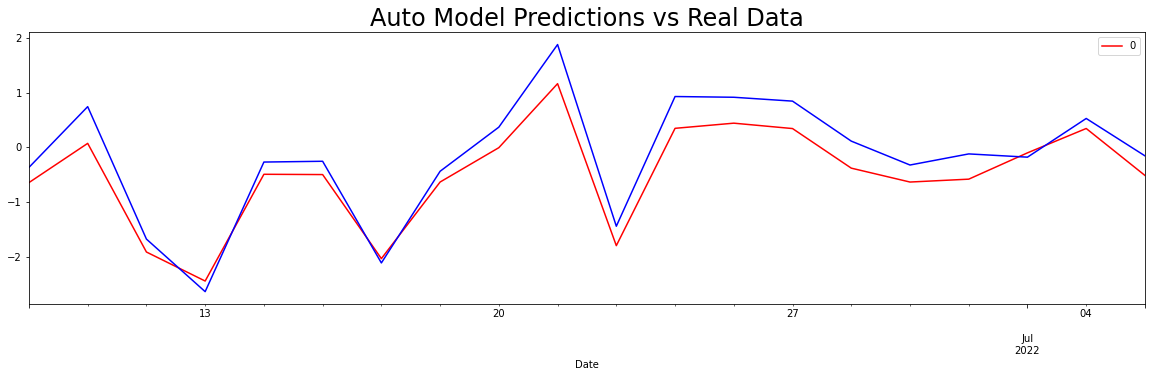

In [76]:
df_auto_pred[-20:].plot(figsize = (20,5), color = "red")
valid.ret_nifty[-20:].plot(color = "blue",label="Test Data")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [77]:

new_model = sm.tsa.SARIMAX(train.ret_kpi[para_index:],order=order,seasonal_order=seasonal_order,trend=trend,
                            exog = train[['ret_nifty','Qkpi']][para_index:])
fit_sarima = new_model.fit()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06825D+00    |proj g|=  4.40246D+07


/Users/vipinv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      1     21      1     0     0   4.402D+07   2.068D+00
  F =   2.0682506580588145     

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [104]:
# train.tail()
limiter = 20
prediction = fit_sarima.forecast(steps=limiter,exog=valid[['ret_nifty','Qkpi']][0:20], dynamic=True)
print(prediction)

2019-08-12   -0.208115
2019-08-13   -1.418632
2019-08-14    0.558223
2019-08-15   -0.245172
2019-08-16   -0.379789
2019-08-19   -0.546409
2019-08-20   -0.896735
2019-08-21   -1.138374
2019-08-22   -1.675431
2019-08-23    0.792893
2019-08-26    2.249199
2019-08-27    0.328389
2019-08-28   -0.599054
2019-08-29   -0.677085
2019-08-30    0.386911
2019-09-02   -0.181672
2019-09-03   -1.937458
2019-09-04   -0.016253
2019-09-05   -0.317697
2019-09-06    0.348477
Freq: B, Name: predicted_mean, dtype: float64


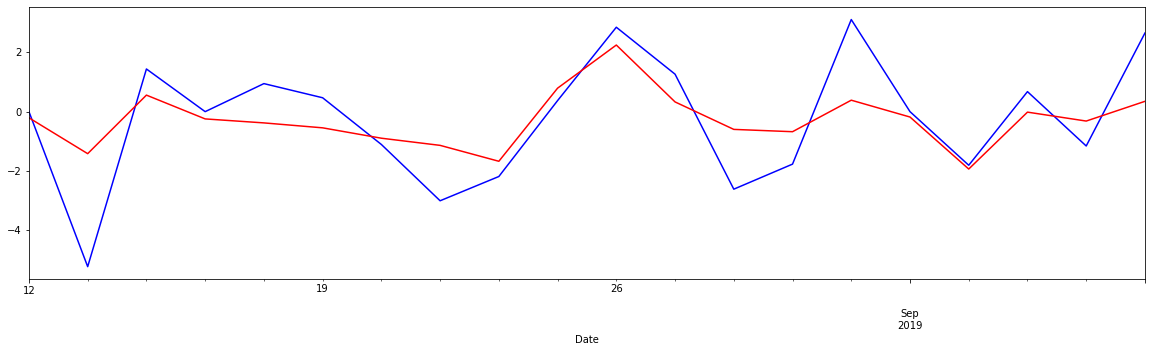

In [105]:
prediction_series = pd.Series(prediction)
valid[0:limiter].ret_kpi.plot(color = "blue",figsize = (20,5))
prediction_series.plot(color = "red")
plt.show()